In [19]:
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))

In [34]:
import torch as torch
from torch.distributions import MultivariateNormal
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# import parametric_pushforward.parametric_ode_solvers

import numpy as np 
import matplotlib.pyplot as plt

import parametric_pushforward.data_sets as toy_data
from parametric_pushforward.parametric_mlp import order_state_to_tensor
from parametric_pushforward.visualization import path_visualization_snapshots, path_visualization_with_trajectories
from parametric_pushforward.spline import Assemble_spline
from parametric_pushforward.obstacles import obstacle_cost_stunnel, obstacle_cost_vneck, obstacle_cost_gmm,congestion_cost,geodesic
from parametric_pushforward.opinion import PolarizeDyn
from parametric_pushforward.setup_density_path_problem import load_boundary_models,get_activation,opinion_dynamics_setup,get_potential_functions

import os
import yaml


In [35]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)

In [36]:
# name of experiment
exp_dir = str(root_path)+ '/experiments/gaussian0_to_gaussian1_pot_congestion_cost_obstacle_cost_stunnel_20250316_215830'
yaml_path = os.path.join(exp_dir, 'config.yaml')
with open(yaml_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [37]:

name_data0 = config['data']['source']['name']
checkpt0 = 'final'#'checkpoint_1999'
name_data1 = config['data']['target']['name']
checkpt1 = 'final'#'checkpoint_1999'

arch_dims = [config['architecture']['input_dim'],config['architecture']['hidden_dim'],config['architecture']['num_layers']]
activation = get_activation(config['architecture']['activation'])

arch = arch_dims+[activation]

spline_type = config['spline']['type']


prior = MultivariateNormal(torch.zeros(2).to(device),torch.eye(2).to(device))

state0,state1 = load_boundary_models(config,device)
theta0 = order_state_to_tensor(state0)
theta1 = order_state_to_tensor(state1)

if config.get('opinion_dynamics',{}).get('active',False):
    print('Opinion dynamics active')
    opinion_dynamics = opinion_dynamics_setup(config)
    ke_modifier = [PolarizeDyn(opinion_dynamics).to(device)]
else:
    ke_modifier = None


In [39]:
# Build spline
num_collocation = config['spline']['num_collocation']
spline0,t = Assemble_spline(theta0=theta0,
                            theta1=theta1,
                            arch=arch,
                            data0=name_data0,
                            data1=name_data1,
                            ke_modifier=ke_modifier,
                            potential=get_potential_functions(config['potential_functions']),
                            number_of_knots=num_collocation,
                            spline=spline_type,
                            device = device,
                            prior_dist=prior)

spline0.sigma = config['coefficients_potentials']['sigma']


In [46]:

spline_path = os.path.join(exp_dir, 'checkpoints/spline.pth') #geo_initial / initial / spline
try:
    state_spline0 = torch.load(spline_path,map_location=device)#['ema_model']
    spline0.load_state_dict(state_spline0)
except:
    state_spline0 = torch.load(spline_path,map_location=device)['ema_model']
    spline0.load_state_dict(state_spline0)

spline0.eval()
spline0.sigma

1.0

In [47]:
samples_per_gaussian = 1000
t_node = 10
x0 = torch.from_numpy(toy_data.inf_train_gen(name_data0, batch_size=8*samples_per_gaussian,dim = config['architecture']['input_dim'])).float().to(device)
x1 = torch.from_numpy(toy_data.inf_train_gen(name_data1, batch_size=8*samples_per_gaussian,dim = config['architecture']['input_dim'])).float().to(device)
# Get z values by flowing backwards
z0 = spline0.pull_back(spline0.x0.flatten(),x0)
y0 = spline0.push_forward(spline0.x1.flatten(),z0)


# z0 = spline0.prior_dist.sample((samples_per_gaussian*8,)).to(device)
# z1 = z0.clone()

Text(0.5, 1.0, 'Induced coupling')

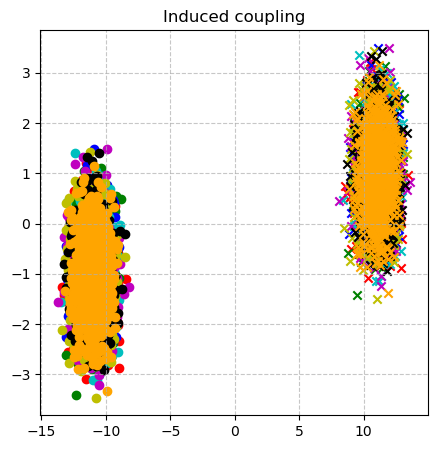

In [48]:
# For checkboard or 8gmm coupling visualization

colors = ['r','g','b','c','m','y','k','orange']
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.grid(True,linestyle = '--',alpha = 0.7)
for i in range(8):
    plt.scatter(x0[i*samples_per_gaussian:(i+1)*samples_per_gaussian,0].cpu().detach().numpy(),x0[i*samples_per_gaussian:(i+1)*samples_per_gaussian,1].cpu().detach().numpy(),color=colors[i])
    plt.scatter(y0[i*samples_per_gaussian:(i+1)*samples_per_gaussian,0].cpu().detach().numpy(),y0[i*samples_per_gaussian:(i+1)*samples_per_gaussian,1].cpu().detach().numpy(),color=colors[i],marker='x')

plt.title('Induced coupling')

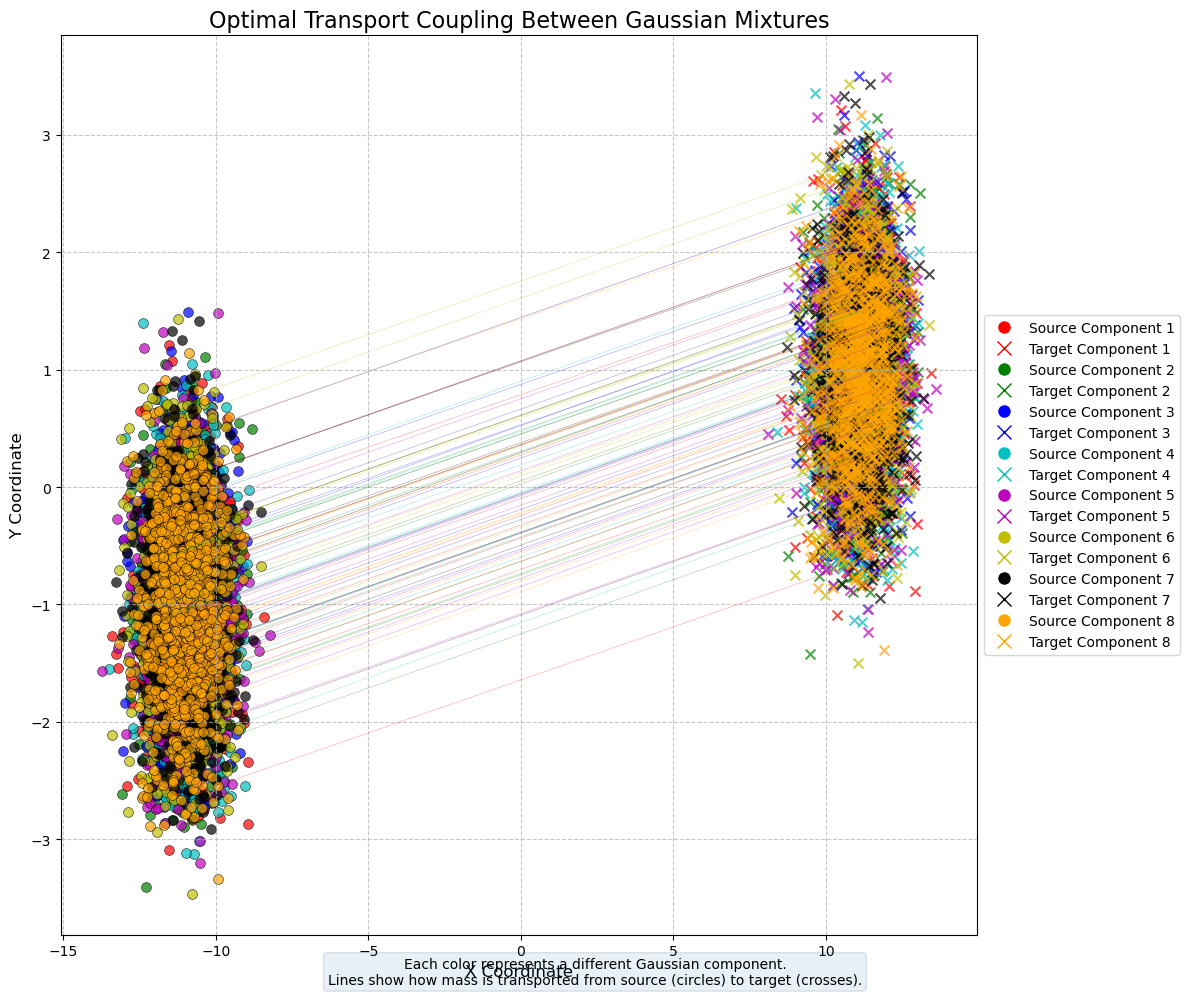

In [49]:
# Enhanced basic coupling visualization
plt.figure(figsize=(12, 10))

# Add a light grid
plt.grid(True, linestyle='--', alpha=0.7)

# Plot with improved markers and add connecting lines
for i in range(8):
    source_points = x0[i*samples_per_gaussian:(i+1)*samples_per_gaussian]
    target_points = y0[i*samples_per_gaussian:(i+1)*samples_per_gaussian]
    
    # Plot points with better visibility
    plt.scatter(source_points[:,0].cpu().detach().numpy(), 
                source_points[:,1].cpu().detach().numpy(),
                color=colors[i], alpha=0.7, s=50, edgecolors='black', linewidths=0.5)
    
    plt.scatter(target_points[:,0].cpu().detach().numpy(), 
                target_points[:,1].cpu().detach().numpy(),
                color=colors[i], alpha=0.7, marker='x', s=50, linewidths=1.5)
    
    # Add connecting lines for a subset of points to avoid overcrowding
    for j in range(min(10, samples_per_gaussian)):
        plt.plot([source_points[j,0].item(), target_points[j,0].item()],
                 [source_points[j,1].item(), target_points[j,1].item()],
                 color=colors[i], alpha=0.3, linewidth=0.5)

# Create a more informative legend
legend_elements = []
for i in range(8):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=colors[i], markersize=10, 
                          label=f'Source Component {i+1}'))
    legend_elements.append(plt.Line2D([0], [0], marker='x', color=colors[i],
                          markersize=10, linewidth=0, 
                          label=f'Target Component {i+1}'))

plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

# Add informative labels and title
plt.title('Optimal Transport Coupling Between Gaussian Mixtures', fontsize=16)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)

# Add explanatory text
plt.figtext(0.5, 0.01, 
           'Each color represents a different Gaussian component.\n'
           'Lines show how mass is transported from source (circles) to target (crosses).',
           ha='center', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()

In [50]:
# Path plot

s = torch.linspace(0,1,40).to(device)

/work2/Sebas/conda_envs/PDPO/lib/python3.12/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

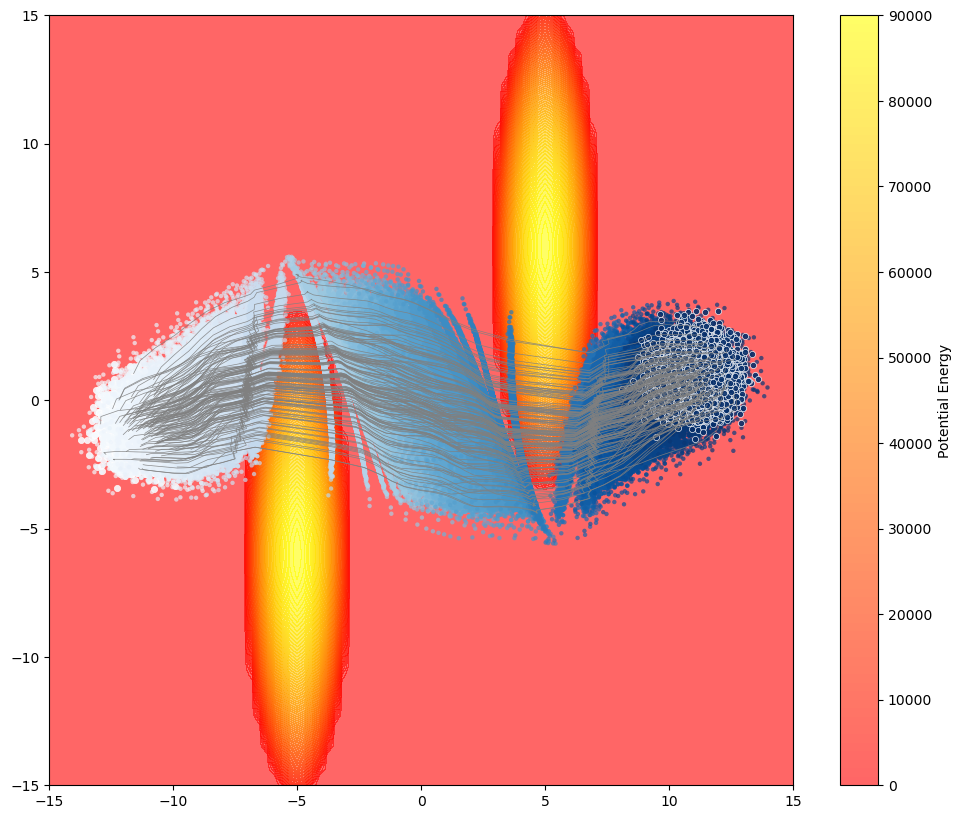

: 

In [55]:

interpolation0 = spline0(t)
samples_path0 = path_visualization_with_trajectories(interpolation=interpolation0,arch = arch,
spline = spline0,
x0 = config['visualization']['plot_bounds']['x_min'],
y0 = config['visualization']['plot_bounds']['y_min'],
x1 = config['visualization']['plot_bounds']['x_max'],
y1 = config['visualization']['plot_bounds']['y_max'],
num_samples = 50,
time_steps = 10,solver = 'midpoint',
z = z0,num_contour_points = 100)

/work2/Sebas/Parametric_Density_Path_Opt/Parametric_pushforward/parametric_pushforward/visualization.py:414: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.07, 0.9, 0.95])


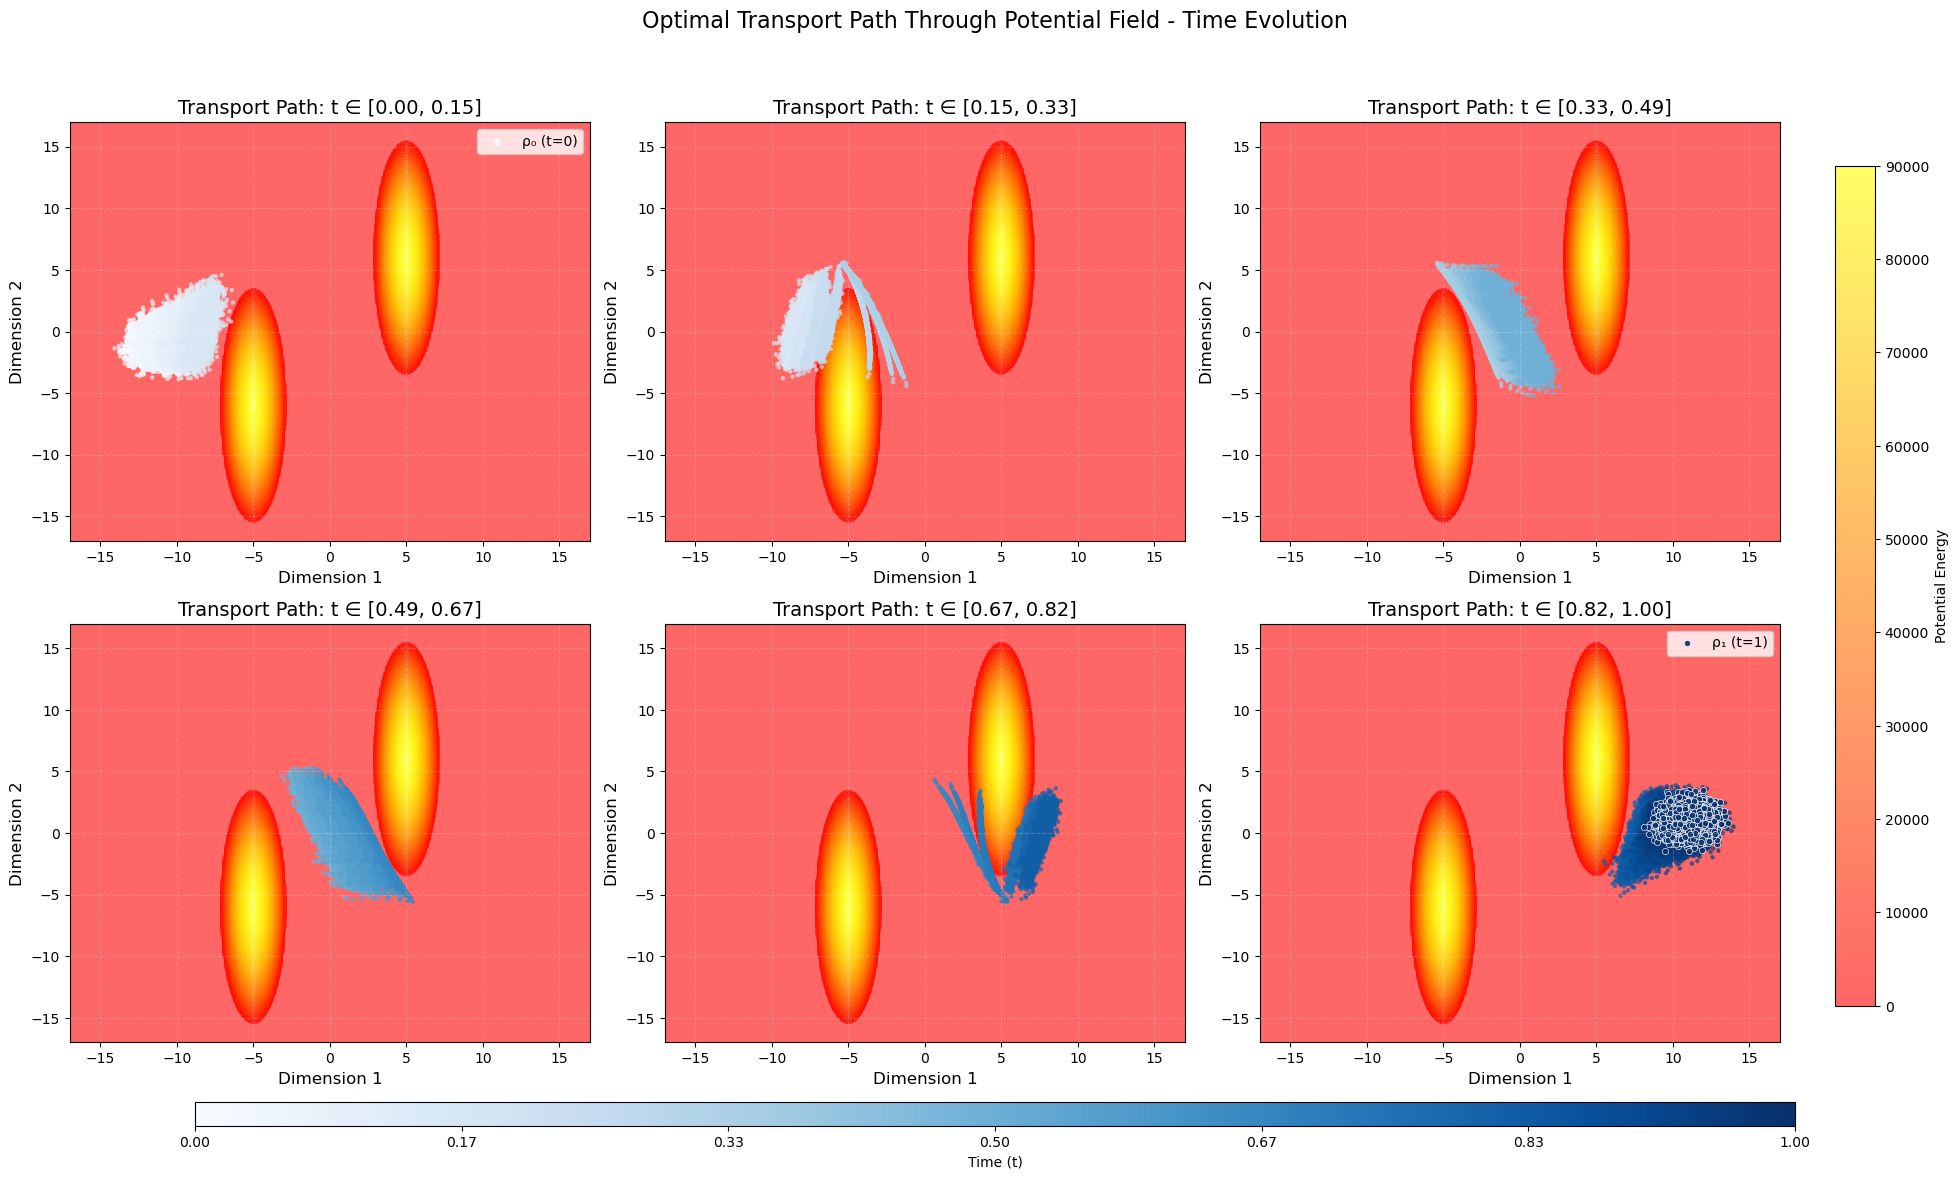

In [52]:
interpolation0 = spline0(s)
samples_path0 = path_visualization_snapshots(interpolation=interpolation0,arch = arch,
spline = spline0,
x0 = config['visualization']['plot_bounds']['x_min']-2,
y0 = config['visualization']['plot_bounds']['y_min']-2,
x1 = config['visualization']['plot_bounds']['x_max']+2,
y1 = config['visualization']['plot_bounds']['y_max']+2,
num_samples = 50,
time_steps = 10,solver = 'midpoint',
z = z0,num_contour_points = 250)

In [54]:
animation = create_particle_animation(spline0,samples_path0.detach().cpu().permute(1,0,2),interval=250)
display(animation)

NameError: name 'create_particle_animation' is not defined